In [1]:
import importlib.util
import os
import sys
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from data_loader import MyDataLoader, SPLIT
from my_config import MyConfig, load_config
import numpy as np
import pandas as pd

In [2]:
def load_module_from_folder(folder_path: str, module_name: str):
    """
    Dynamically load a module from <folder_path>/<module_name>.py
    and return the imported module object.
    """
    module_path = os.path.join(folder_path, f"{module_name}.py")
    if not os.path.isfile(module_path):
        raise FileNotFoundError(f"No such file: {module_path}")

    spec = importlib.util.spec_from_file_location(module_name, module_path)
    module = importlib.util.module_from_spec(spec)
    # make it available in sys.modules in case it imports other local files
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module


# Example usage:
run_folder = Path(r'D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\20250527-111633')
model_mod = load_module_from_folder(run_folder, "models")
train_mod = load_module_from_folder(run_folder, "train")


# Load checkpoint

In [3]:
# Find all checkpoint files in the directory following the pattern checkpoint_{epoch}.pt
checkpoint_files = [f for f in os.listdir(run_folder) if f.startswith('checkpoint_') and f.endswith('.pt')]
if checkpoint_files:
    # Sort files by epoch number in descending order and choose the latest checkpoint.
    checkpoint_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]), reverse=True)
    latest_checkpoint_file = checkpoint_files[0]
    print(f"Loading latest checkpoint: {latest_checkpoint_file}")

    train_mod.model.load_state_dict(torch.load(run_folder / latest_checkpoint_file, map_location=train_mod.DEVICE)['model_state_dict'])
else:
    raise FileNotFoundError(f"No checkpoint files found in {run_folder}")

Loading latest checkpoint: checkpoint_5.pt


# Load test data

In [4]:
my_config: MyConfig = load_config(run_folder / 'config.json')
data_loader = MyDataLoader(my_config)
data_loader.load_data()
data_loader.reindex_full_range()
data_loader.lag_features()
data_loader.prepare_df(drop_solar_altitude_below_0=False, drop_nan=False)
scalar_file = run_folder / 'scaler.pkl'





X, y, ts = data_loader.get_X_y(SPLIT.TEST, input_seq_len=60, rolling=True, verbose=True)
test_dataset = train_mod.TimeSeriesDataset(X, y, device=train_mod.DEVICE)
test_loader = DataLoader(test_dataset, batch_size=train_mod.BATCH_SIZE, shuffle=False)

Before creating sequences: X shape: (1051201, 11), y shape: (1051201, 1)
After creating sequences: X shape: (1051141, 60, 11), y shape: (1051141, 60, 1)


In [5]:
data_loader.get_split(SPLIT.TEST)

,DNI,DNI_lag_60,DNI_lag_1440,DNI_lag_2880,air_pressure_lag_60,air_temperature_lag_60,rain_duration_lag_60,rain_intensity_lag_60,relative_humidity_lag_60,solar_altitude,wind_dir_avg_lag_60,wind_speed_avg_lag_60
2023-01-01 00:00:00,0.000,0.000000,0.000000,0.000000,0.952874,0.465228,0.857143,0.002431,0.950159,0.013225,0.568471,0.161016
2023-01-01 00:01:00,0.000,0.000000,0.000000,0.000000,0.952874,0.465228,0.857143,0.006483,0.950159,0.013639,0.610857,0.174333
2023-01-01 00:02:00,0.000,0.000000,0.000000,0.000000,0.952874,0.465228,0.857143,0.008104,0.950159,0.014060,0.638283,0.154358
2023-01-01 00:03:00,0.000,0.000000,0.000000,0.000000,0.952969,0.465228,0.857143,0.008104,0.950159,0.014489,0.568471,0.204297
2023-01-01 00:04:00,0.000,0.000000,0.000000,0.000000,0.952969,0.465228,0.857143,0.010535,0.950159,0.014927,0.600884,0.210956
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:56:00,0.165,0.000147,0.000047,0.000204,0.964559,0.446043,0.000000,0.000000,0.908802,0.011423,0.718068,0.350786
2024-12-30 23:57:00,0.162,0.000170,0.000025,0.000182,0.964559,0.446043,0.000000,0.000000,0.908802,0.011806,0.650750,0.310835
2024-12-30 23:58:00,0.146,0.000168,0.000055,0.000158,0.964559,0.443645,0.000000,0.000000,0.909862,0.012197,0.645763,0.230931
2024-12-30 23:59:00,0.128,0.000186,0.000039,0.000143,0.964559,0.443645,0.000000,0.000000,0.909862,0.012596,0.665709,0.324152


# Make predictions

In [6]:
train_mod.model.eval()
preds = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(train_mod.DEVICE), batch_y.to(train_mod.DEVICE)
        predictions = train_mod.model(batch_X)
        preds.append(predictions.cpu().numpy())

y_test = y.squeeze()
preds = np.concatenate(preds).squeeze()
display(ts.shape, y_test.shape, preds.shape)

(1051141, 60)

(1051141, 60)

(1051141, 60)

In [7]:
y_test = pd.DataFrame(y_test, index=ts[:, 0])
preds = pd.DataFrame(preds, index=ts[:, 0])
ts = pd.DataFrame(ts, index=ts[:, 0])
y_test.sort_index(inplace=True)
preds.sort_index(inplace=True)
display(y_test.head(), preds.head(), ts.head())

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2023-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.007520,0.000000,0.004607,0.005631
2023-01-01 00:01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.00000,0.000000,0.007520,0.000000,0.004607,0.005631,0.011060
2023-01-01 00:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.00000,0.007520,0.000000,0.004607,0.005631,0.011060,0.002382
2023-01-01 00:03:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.00752,0.000000,0.004607,0.005631,0.011060,0.002382,0.012128
2023-01-01 00:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00752,0.00000,0.004607,0.005631,0.011060,0.002382,0.012128,0.005926


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2023-01-01 00:00:00,1.014722,0.776037,0.545565,0.351349,0.212370,0.122244,0.067558,0.034805,0.014772,0.003442,...,-0.005622,-0.006364,-0.006564,-0.007059,-0.007841,-0.007869,-0.008676,-0.008568,-0.010401,-0.010841
2023-01-01 00:01:00,1.014283,0.775186,0.544754,0.350276,0.211056,0.122240,0.067819,0.034476,0.015067,0.001820,...,-0.006364,-0.006564,-0.007059,-0.007841,-0.007869,-0.008676,-0.008568,-0.010401,-0.010841,-0.010817
2023-01-01 00:02:00,1.014366,0.775457,0.544526,0.349468,0.211399,0.122774,0.067680,0.034892,0.013500,0.002648,...,-0.006564,-0.007059,-0.007841,-0.007869,-0.008676,-0.008568,-0.010401,-0.010841,-0.010817,-0.010473
2023-01-01 00:03:00,1.014183,0.774429,0.542790,0.349144,0.211648,0.122516,0.068063,0.033329,0.014337,0.003477,...,-0.007059,-0.007841,-0.007869,-0.008676,-0.008568,-0.010401,-0.010841,-0.010817,-0.010473,-0.009300
2023-01-01 00:04:00,1.013895,0.773786,0.543477,0.350205,0.211855,0.123122,0.066535,0.034114,0.015134,0.003275,...,-0.007841,-0.007869,-0.008676,-0.008568,-0.010401,-0.010841,-0.010817,-0.010473,-0.009300,-0.008256


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:01:00,2023-01-01 00:02:00,2023-01-01 00:03:00,2023-01-01 00:04:00,2023-01-01 00:05:00,2023-01-01 00:06:00,2023-01-01 00:07:00,2023-01-01 00:08:00,2023-01-01 00:09:00,...,2023-01-01 00:50:00,2023-01-01 00:51:00,2023-01-01 00:52:00,2023-01-01 00:53:00,2023-01-01 00:54:00,2023-01-01 00:55:00,2023-01-01 00:56:00,2023-01-01 00:57:00,2023-01-01 00:58:00,2023-01-01 00:59:00
2023-01-01 00:01:00,2023-01-01 00:01:00,2023-01-01 00:02:00,2023-01-01 00:03:00,2023-01-01 00:04:00,2023-01-01 00:05:00,2023-01-01 00:06:00,2023-01-01 00:07:00,2023-01-01 00:08:00,2023-01-01 00:09:00,2023-01-01 00:10:00,...,2023-01-01 00:51:00,2023-01-01 00:52:00,2023-01-01 00:53:00,2023-01-01 00:54:00,2023-01-01 00:55:00,2023-01-01 00:56:00,2023-01-01 00:57:00,2023-01-01 00:58:00,2023-01-01 00:59:00,2023-01-01 01:00:00
2023-01-01 00:02:00,2023-01-01 00:02:00,2023-01-01 00:03:00,2023-01-01 00:04:00,2023-01-01 00:05:00,2023-01-01 00:06:00,2023-01-01 00:07:00,2023-01-01 00:08:00,2023-01-01 00:09:00,2023-01-01 00:10:00,2023-01-01 00:11:00,...,2023-01-01 00:52:00,2023-01-01 00:53:00,2023-01-01 00:54:00,2023-01-01 00:55:00,2023-01-01 00:56:00,2023-01-01 00:57:00,2023-01-01 00:58:00,2023-01-01 00:59:00,2023-01-01 01:00:00,2023-01-01 01:01:00
2023-01-01 00:03:00,2023-01-01 00:03:00,2023-01-01 00:04:00,2023-01-01 00:05:00,2023-01-01 00:06:00,2023-01-01 00:07:00,2023-01-01 00:08:00,2023-01-01 00:09:00,2023-01-01 00:10:00,2023-01-01 00:11:00,2023-01-01 00:12:00,...,2023-01-01 00:53:00,2023-01-01 00:54:00,2023-01-01 00:55:00,2023-01-01 00:56:00,2023-01-01 00:57:00,2023-01-01 00:58:00,2023-01-01 00:59:00,2023-01-01 01:00:00,2023-01-01 01:01:00,2023-01-01 01:02:00
2023-01-01 00:04:00,2023-01-01 00:04:00,2023-01-01 00:05:00,2023-01-01 00:06:00,2023-01-01 00:07:00,2023-01-01 00:08:00,2023-01-01 00:09:00,2023-01-01 00:10:00,2023-01-01 00:11:00,2023-01-01 00:12:00,2023-01-01 00:13:00,...,2023-01-01 00:54:00,2023-01-01 00:55:00,2023-01-01 00:56:00,2023-01-01 00:57:00,2023-01-01 00:58:00,2023-01-01 00:59:00,2023-01-01 01:00:00,2023-01-01 01:01:00,2023-01-01 01:02:00,2023-01-01 01:03:00


# Plot predictions

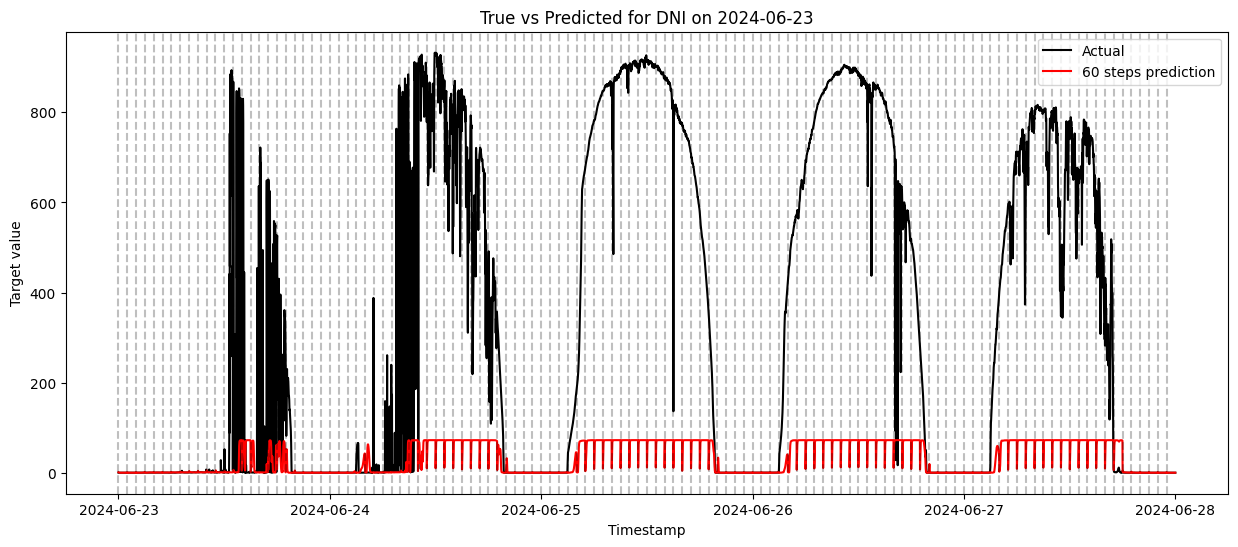

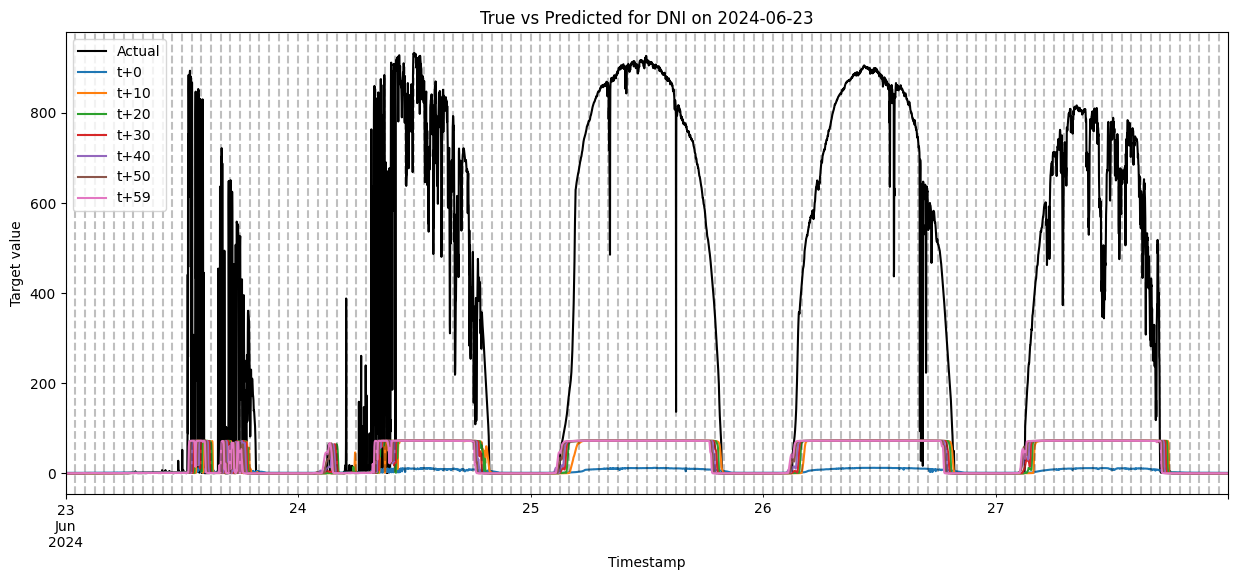

In [8]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))
# Select a specific day
day = '2024-06-23'
day_start = pd.to_datetime(day)
day_end = day_start + pd.Timedelta(days=5)
# Filter the timestamps for the selected day
day_mask = (ts.index >= day_start) & (ts.index < day_end)
day_ts = ts[day_mask][0].values

# Plot actual values
ax.plot(day_ts, y_test[day_mask][0].values, label='Actual', color='black')
ax.plot(day_ts, preds[day_mask][::60].values.flatten()[:len(day_ts)], label='60 steps prediction', color='red')
# add vertical lines at every 60th timestep
for i in range(0, len(day_ts), 60):
    ax.axvline(x=day_ts[i], color='black', linestyle='--', alpha=0.25)

ax.set_title(f"True vs Predicted for {my_config.TARGETS[0]} on {day}")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Target value")
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15, 6))
y_test[day_mask][0].plot(ax=ax, label='Actual', color='black', title=f"True vs Predicted for {my_config.TARGETS[0]} on {day}", xlabel="Timestamp", ylabel="Target value", legend=True)
prediction_steps = list(range(0, 60, 10))
prediction_steps.append(59)
for i in prediction_steps:
    preds[day_mask][::1][i].plot(ax=ax, label=f"t+{i}", legend=True)

for i in range(0, len(day_ts), 60):
    ax.axvline(x=day_ts[i], color='black', linestyle='--', alpha=0.25)

plt.show()

In [9]:
from ForecastEvaluator import ForecastEvaluator


def calculate_errors(y_true, y_pred):
    return ForecastEvaluator(y_true, y_pred).evaluate_all()


error_metrics = {}
for i in range(60):
    error_metrics[f't+{i}'] = calculate_errors(y_test[0], preds[i])

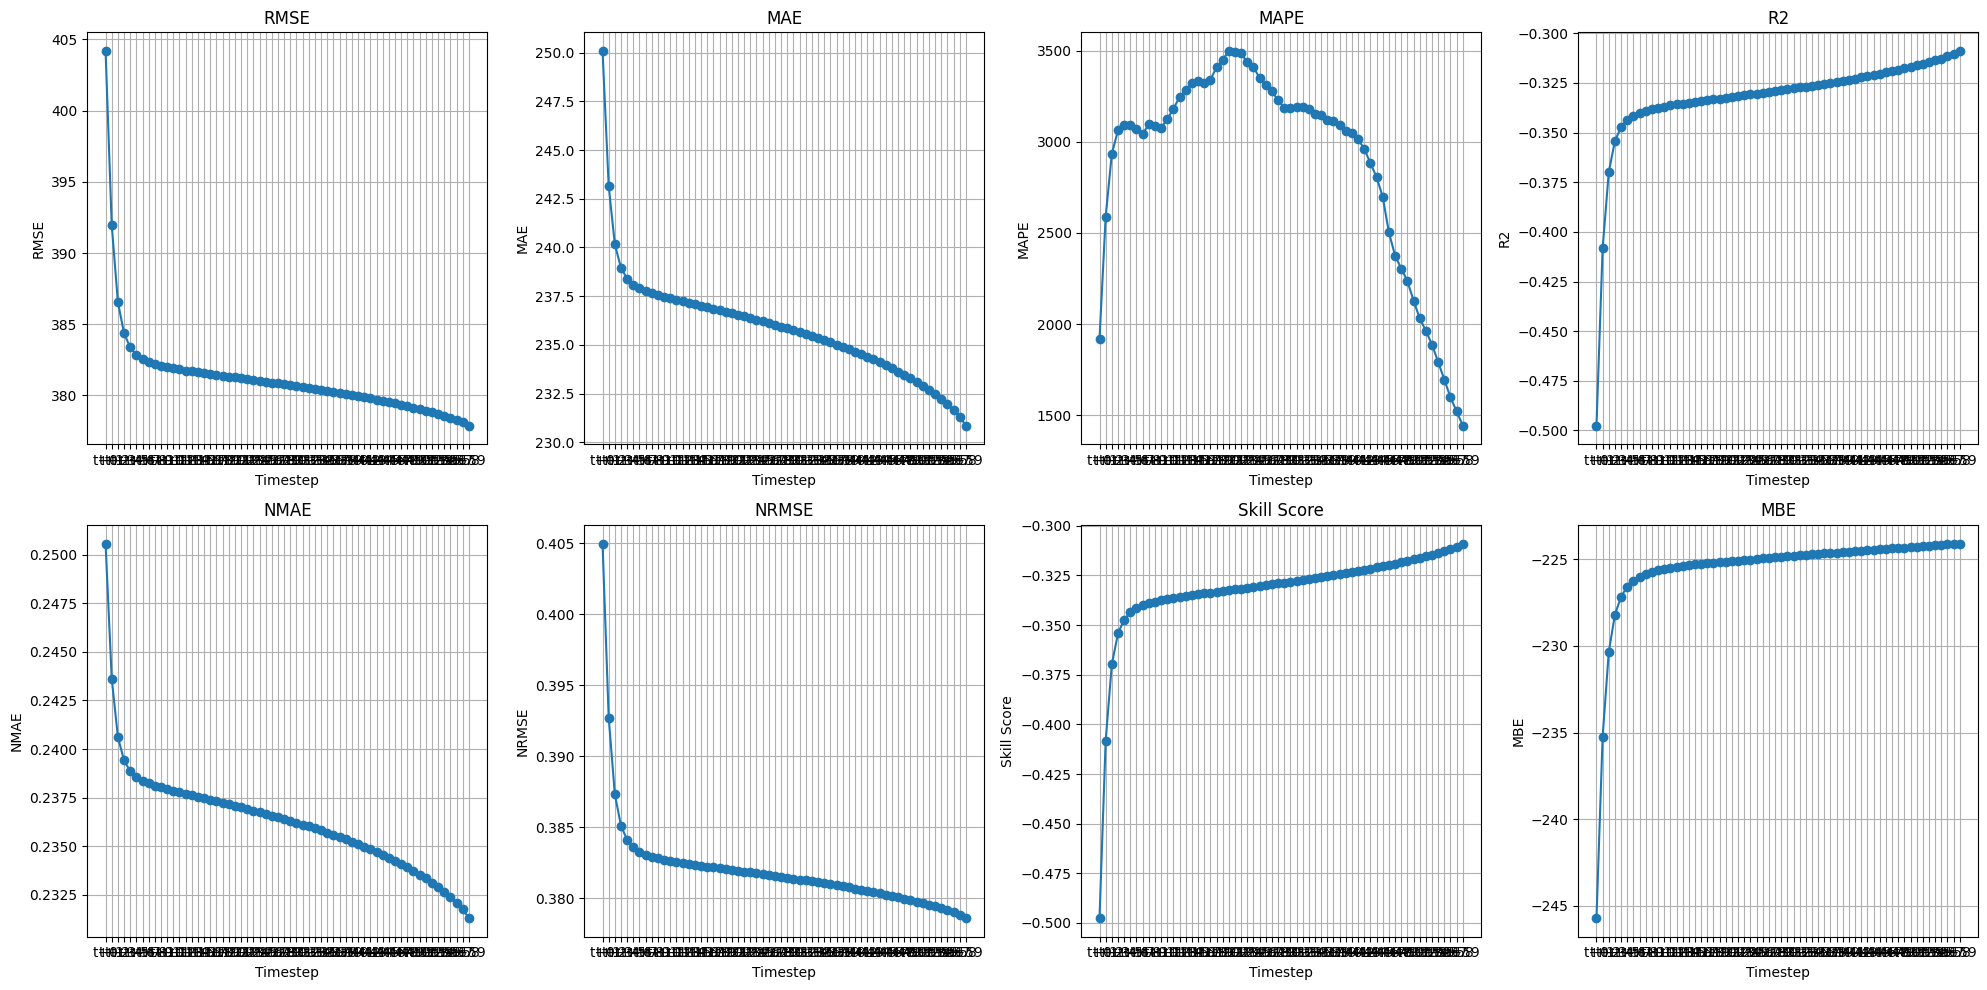

In [10]:
# Extract the timestep keys and error metrics
timesteps = list(error_metrics.keys())
metrics = list(error_metrics['t+56'].keys())

# Prepare figure and axes for subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

# Plot each metric on a separate subplot
for i, metric in enumerate(metrics):
    values = [error_metrics[ts][metric] for ts in timesteps]
    axs[i].plot(timesteps, values, marker='o')
    axs[i].set_title(metric)
    axs[i].set_xlabel('Timestep')
    axs[i].set_ylabel(metric)
    axs[i].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [11]:
y_test.to_pickle(r'LSTM_y_test.pkl')
preds.to_pickle(r'LSTM_preds.pkl')